<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Useful-Websites" data-toc-modified-id="Useful-Websites-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Useful Websites</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Generic-Function" data-toc-modified-id="Generic-Function-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Generic Function</a></span></li><li><span><a href="#UK" data-toc-modified-id="UK-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>UK</a></span></li><li><span><a href="#USA" data-toc-modified-id="USA-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>USA</a></span></li><li><span><a href="#China" data-toc-modified-id="China-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>China</a></span></li><li><span><a href="#Italy" data-toc-modified-id="Italy-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Italy</a></span></li><li><span><a href="#Germany" data-toc-modified-id="Germany-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Germany</a></span></li><li><span><a href="#Singapore" data-toc-modified-id="Singapore-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Singapore</a></span></li><li><span><a href="#Spain" data-toc-modified-id="Spain-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Spain</a></span></li><li><span><a href="#Korea,-South" data-toc-modified-id="Korea,-South-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>Korea, South</a></span></li><li><span><a href="#Netherlands" data-toc-modified-id="Netherlands-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Netherlands</a></span></li><li><span><a href="#Ireland" data-toc-modified-id="Ireland-13"><span class="toc-item-num">13&nbsp;&nbsp;</span>Ireland</a></span></li><li><span><a href="#Romania" data-toc-modified-id="Romania-14"><span class="toc-item-num">14&nbsp;&nbsp;</span>Romania</a></span></li><li><span><a href="#France" data-toc-modified-id="France-15"><span class="toc-item-num">15&nbsp;&nbsp;</span>France</a></span></li><li><span><a href="#Australia" data-toc-modified-id="Australia-16"><span class="toc-item-num">16&nbsp;&nbsp;</span>Australia</a></span></li><li><span><a href="#Sweden" data-toc-modified-id="Sweden-17"><span class="toc-item-num">17&nbsp;&nbsp;</span>Sweden</a></span></li><li><span><a href="#Comparison" data-toc-modified-id="Comparison-18"><span class="toc-item-num">18&nbsp;&nbsp;</span>Comparison</a></span></li></ul></div>

In [29]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Hide code."></form>''')

# Overview
## Useful Websites
World:
* https://www.worldometers.info/coronavirus/#countries

UK specific:
* https://www.arcgis.com/apps/opsdashboard/index.html#/f94c3c90da5b4e9f9a0b19484dd4bb14
* https://www.gov.uk/guidance/coronavirus-covid-19-information-for-the-public#number-of-cases

Country codes:
* https://www.iban.com/country-codes

## EDA
The data is updated daily as a csv file, which makes this analysis fairly easy to get started. Let's check the data for the UK, and explore what the growth looks like.

In [185]:
from urllib.request import urlretrieve

file = 'time_series_19-covid-Confirmed.csv'
old_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
path = '../data/raw/'

url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'

urlretrieve(url, path+file)

('../data/raw/time_series_19-covid-Confirmed.csv',
 <http.client.HTTPMessage at 0x1a19eea278>)

In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('talk')

df = pd.read_csv(path+file)
df.shape

(253, 72)

In [187]:
# Set blank province to the country/region name
idx = df['Province/State'].isna()
df.loc[idx, 'Province/State'] = df.loc[idx, 'Country/Region']

In [188]:
tidy_df = df.melt(id_vars=['Province/State', 'Lat', 'Long', 'Country/Region'],
                  value_name='Cases',
                  var_name='Date').reset_index()
tidy_df['Date'] = pd.to_datetime(tidy_df['Date'], format='%m/%d/%y')
tidy_df = tidy_df.set_index('Date').sort_index()
tidy_df['Country/Region'].value_counts().head(10)

China                  2244
Canada                 1020
United Kingdom          680
France                  680
Australia               544
Netherlands             272
Denmark                 204
Antigua and Barbuda      68
Equatorial Guinea        68
Luxembourg               68
Name: Country/Region, dtype: int64

## Generic Function

In [62]:
def add_today(tidy_df, country, value, province=False):
    """ Add todays number to yesterdays data set """
    idx = []
    # Check we haven't already added
    if province:
        idx = tidy_df['Province/State'] == country
    else:
        idx = tidy_df['Country/Region'] == country
    today_dt = pd.to_datetime(pd.Timestamp.now().date())
    
    if tidy_df[idx][today_dt:].shape[0] == 1:
        # set the value
        idx &= tidy_df.index == today_dt
        if idx.sum() == 0:
            print('Broken')
        tidy_df.loc[idx, 'Cases'] = value
    elif tidy_df[idx][today_dt:].shape[0] == 0:
        today = tidy_df[idx].loc[today_dt - pd.Timedelta('1D'):].copy()
        today.index = [pd.Timestamp(today_dt)]
        today['Cases'] = value
        tidy_df = pd.concat([tidy_df, today], axis=0)
    else:
        raise Exception('Too many matching entries')

    return tidy_df

In [63]:
def loss_function(series, strategy='rmse', test=False):
    """ Given a Series of residuals, return a loss score """
    series = series.dropna()
    if series.shape[0] == 0:
        score = np.nan
    elif abs(series.sum()) < 0.001:
        print(series)
        raise Exception('Zero residual sum not possible')
    elif strategy == 'mse':
        score = np.sum(series**2)
    elif strategy == 'rmse':
        score = np.sum(series**2)**0.5
    elif strategy == 'best_fit_last':
        # rmse - but with a final multiple which
        # strongly biases more recent residuals
        half = int(round(len(series)/2.0))
        blank = np.zeros(half)
        mult = np.linspace(1, 2, int(len(series)-half))**2
        mult = np.concatenate([blank, mult])
        score = series**2
        score = np.multiply(mult, score)
        score = np.sum(score)**0.5
        if test:
            print(mult)
    return score

test = pd.Series(np.linspace(0,0.9,10))

print(loss_function(test, strategy='mse', test=True))
print(loss_function(test, strategy='rmse', test=True))
print(loss_function(test, strategy='best_fit_last', test=True))

2.8500000000000005
1.6881943016134133
[0.     0.     0.     0.     0.     1.     1.5625 2.25   3.0625 4.    ]
2.6673957336698284


In [64]:
def sig_pred_case(i, duration=70, peak=80000, spread=16):
    numer = peak
    # exp(0) happens at 50% time of infection
    index = i - duration/2
    # in np.exp(y) - we want y to be between -5 and +5
    # 2020-03-14: in np.exp(y) - we want y to be between -8 and +8
    lam = spread/duration
    denom = (1+np.exp(-1*lam*index))
    sig_num = numer/denom
    return sig_num

# Test
test_peak = 80000
test_dur = 70
assert sig_pred_case(0, test_dur, test_peak, 16)/test_peak < 0.001
assert sig_pred_case(test_dur/2, test_dur, test_peak, 16.0)/test_peak == 0.5
assert sig_pred_case(test_dur-1, test_dur, test_peak, 16.0)/test_peak > 0.999

In [65]:
from sklearn.metrics import r2_score


def plot_country(country='United Kingdom',
                 start_str='2020-02-26',
                 peak_guess=120000,
                 duration_guess=79,
                 strategy='rmse',
                 offset=None,
                 spread=16.0):

    if offset:
        pass
    else:
        offset=round(duration_guess/8)
    
    idx = tidy_df['Country/Region'] == country
    df = tidy_df.loc[idx, 'Cases'].resample('D').sum()

    # grid search best RMSE
    score_df = pd.DataFrame({'peak':[], 'duration':[], 'score':[]}).set_index(['peak', 'duration'])

    peak_grid = range(round(0.5*peak_guess),
                      round(1.5*peak_guess),
                      round(0.025*peak_guess))
    
    duration_grid = range(duration_guess-4,
                          duration_guess+3,
                          1)
    for peak in peak_grid:
        for duration in duration_grid:
            sig_case_lst = []
            for i in range(0, duration):
                sig_case_lst.append(sig_pred_case(i, duration, peak, spread=spread))

            current_df = pd.DataFrame(sig_case_lst,
                                      index=pd.date_range(start_str,
                                                          periods=duration))

            conc_df = pd.concat([df[start_str:], current_df], axis=1)
            conc_df.columns = ['Actual', 'Prediction']
            conc_df['residual'] = conc_df['Actual'] - conc_df['Prediction']
            score_df.loc[(peak, duration), 'score'] = loss_function(conc_df['residual'],
                                                                    strategy=strategy)
            

    best_peak, best_duration = score_df['score'].argmin()
    best_score = score_df.loc[(best_peak, best_duration), 'score']

    duration = int(best_duration)
    peak = int(best_peak)

    sig_case_lst = []
    for i in range(0, duration):
        sig_case_lst.append(sig_pred_case(i, duration, peak))


    current_df = pd.DataFrame(sig_case_lst,
                              index=pd.date_range(start_str,
                                                  periods=duration))

    conc_df = pd.concat([df[start_str:], current_df], axis=1)
    conc_df.columns = [ 'Actual', 'Prediction']
    conc_df['residual'] = conc_df['Actual'] - conc_df['Prediction']
    y = conc_df.dropna()['Actual']
    y_pred = conc_df.dropna()['Prediction']
    r2 = r2_score(y, y_pred)

    now_dt = pd.Timestamp.now().date()
    plot_offset = pd.Timedelta(f'{offset}D')
    plot_cols = ['Actual', 'Prediction']    
    fig, ax = plt.subplots(1,1,figsize=(14,10))

    sns.lineplot(data=conc_df.loc[now_dt-plot_offset:now_dt+(plot_offset*2),
                                  plot_cols],
                 ax=ax,
                 marker='o')
    plt.xticks(rotation=90)
    plt.title(f'{country}\nStart: {start_str}\nDuration: {best_duration:.0f}\nPeak: {best_peak:.0f}\nR-squared: {r2:.3f}')
    plt.tight_layout()
    plt.show()
    
    fig, ax = plt.subplots(1,1,figsize=(14, 7))
    conc_df.loc[now_dt-plot_offset:now_dt+(plot_offset*2), plot_cols].diff().plot(kind='bar', ax=ax)
    plt.title(f'{country}\nEstimated Daily new cases')
    plt.tight_layout()
    plt.show()
    return conc_df


## UK

/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/ipykernel_launcher.py:47: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


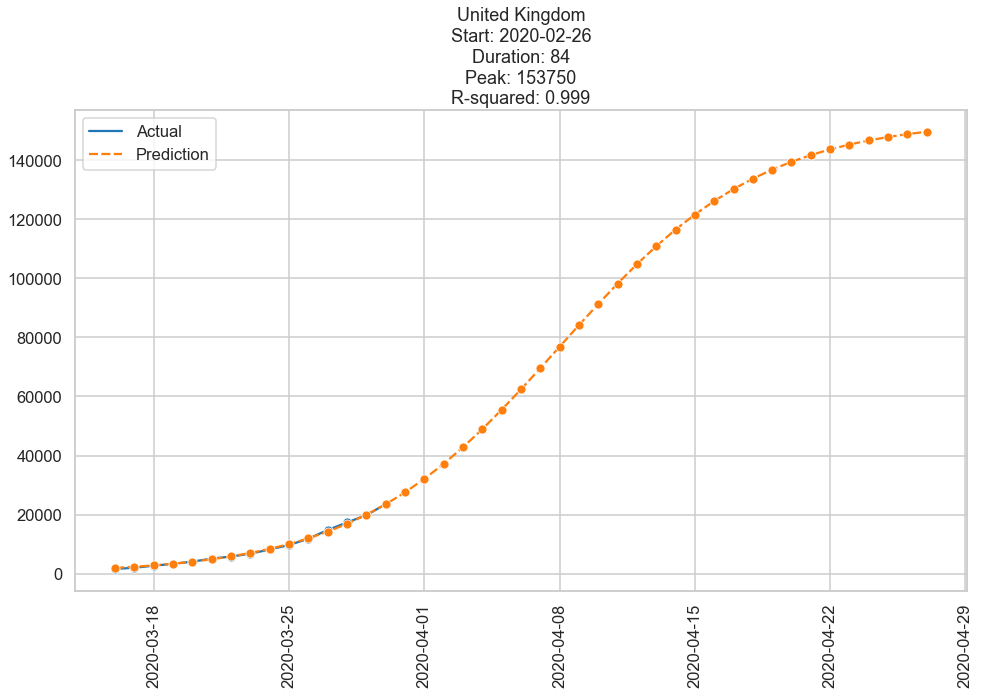

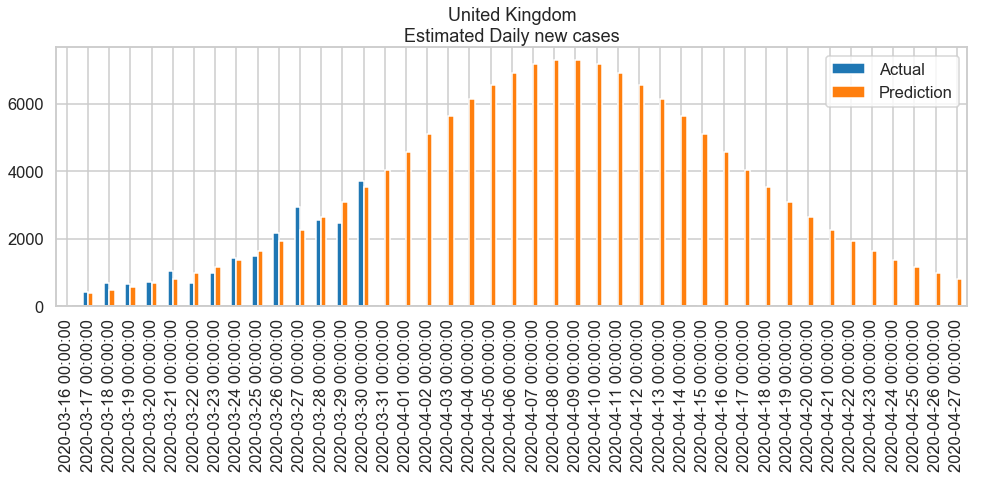

In [193]:
country = 'United Kingdom'
region = np.nan
start_str = '2020-02-26'
peak_guess = 150000
duration_guess = 7*12+4

# fix mistakes in raw data set
idx = tidy_df['Country/Region'] == country
idx &= tidy_df['Province/State'] == country
idx &= tidy_df.index == pd.to_datetime('2020-03-12')
tidy_df.loc[idx, 'Cases'] = 590

idx = tidy_df['Country/Region'] == country
idx &= tidy_df['Province/State'] == country
idx &= tidy_df.index == pd.to_datetime('2020-03-15')
tidy_df.loc[idx, 'Cases'] = 1391

idx = tidy_df['Province/State'] == country
idx &= tidy_df['Country/Region'] == country
idx &= tidy_df.index == pd.to_datetime('2020-03-19')
tidy_df.loc[idx, 'Cases'] = 3269

tidy_df = add_today(tidy_df, country, 23500, province=True)

gb_df = plot_country(country, start_str, peak_guess, duration_guess,
                     offset=14, strategy='best_fit_last')

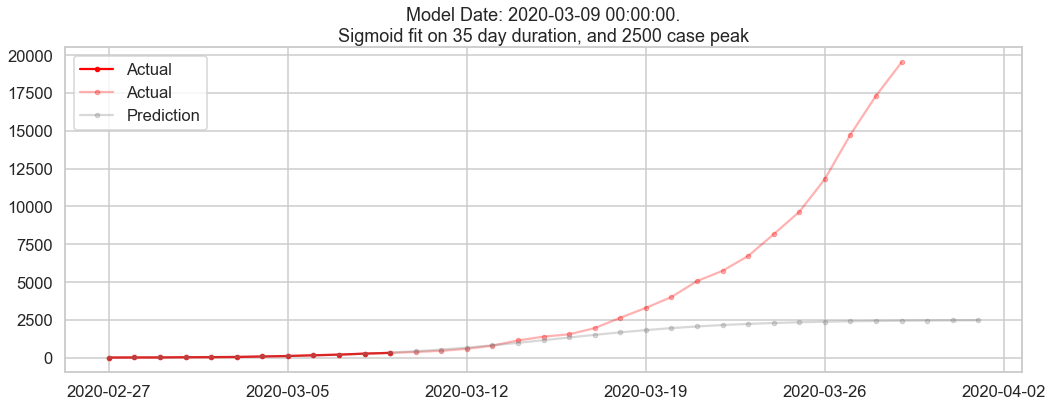

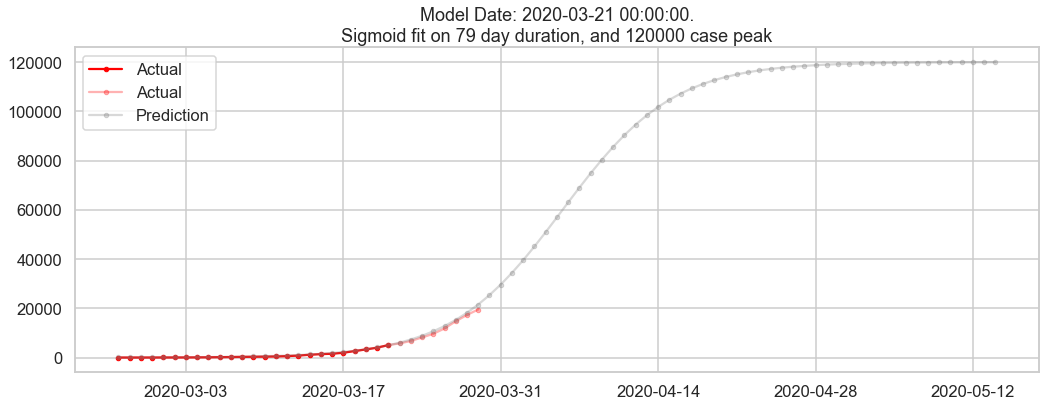

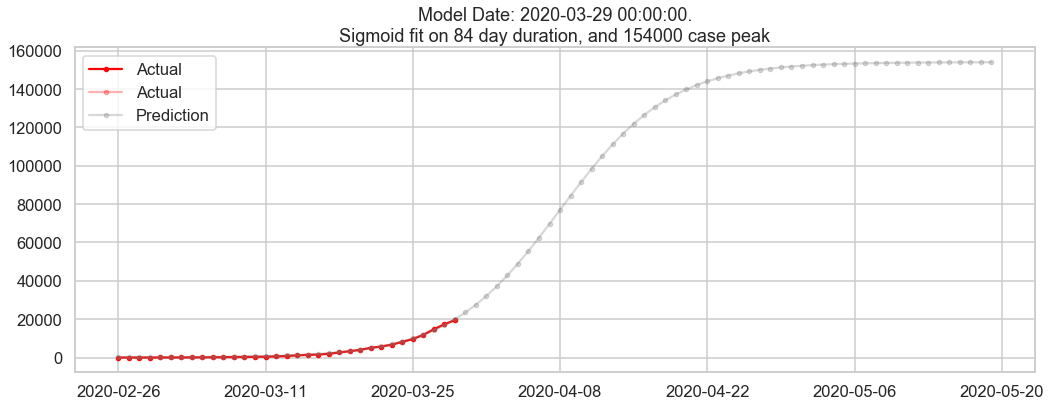

In [182]:
# Track model guess over time
best_fit_df = pd.DataFrame({'date': [pd.to_datetime('2020-03-09'),
                                     pd.to_datetime('2020-03-10'),
                                     pd.to_datetime('2020-03-11'),
                                     pd.to_datetime('2020-03-12'),
                                     pd.to_datetime('2020-03-13'),
                                     pd.to_datetime('2020-03-14'),
                                     pd.to_datetime('2020-03-15'),
                                     pd.to_datetime('2020-03-21'),
                                     pd.to_datetime('2020-03-22'),
                                     pd.to_datetime('2020-03-23'),
                                     pd.to_datetime('2020-03-24'),
                                     pd.to_datetime('2020-03-26'),
                                     pd.to_datetime('2020-03-28'),
                                     pd.to_datetime('2020-03-29'),
                                    ],
                            'start': ['2020-02-27',
                                      '2020-02-27',
                                      '2020-02-27',
                                      '2020-02-27',
                                      '2020-02-27',
                                      '2020-02-27',
                                      '2020-02-27',
                                      '2020-02-26',
                                      '2020-02-26',
                                      '2020-02-26',
                                      '2020-02-26',
                                      '2020-02-26',
                                      '2020-02-26',
                                      '2020-02-26',],
                            'spread': [10,
                                       10,
                                       10,
                                       10,
                                       10,
                                       16,
                                       16,
                                       16,
                                       16,
                                       16,
                                       16,
                                       16,
                                       16,
                                       16,],
                            'duration': [35,
                                         42,
                                         41,
                                         38,
                                         40,
                                         64,
                                         62,
                                         79,
                                         79,
                                         79,
                                         79,
                                         80,
                                         81,
                                         84],
                            'peak': [2500,
                                     3800,
                                     3500,
                                     2850,
                                     3350,
                                     59500,
                                     69000,
                                     120000,
                                     115000,
                                     112000,
                                     114000,
                                     117000,
                                     129000,
                                     154000,]}).set_index('date')


for date in best_fit_df.iloc[[0,round(len(best_fit_df)/2),-1]].index:
    sig_case_lst = []
    duration = best_fit_df.loc[date, 'duration']
    peak = best_fit_df.loc[date, 'peak']
    spread = best_fit_df.loc[date, 'spread']
    start = best_fit_df.loc[date, 'start']
    for i in range(0, duration):
        sig_case_lst.append(sig_pred_case(i, duration=duration, peak=peak, spread=spread))
    pred_df = pd.DataFrame({'Prediction': sig_case_lst}, index=pd.date_range(start, periods=duration))

    fig, ax = plt.subplots(1,1,figsize=(15,6))
    plt.plot(gb_df.loc[start:date, 'Actual'], marker='.', color='red')
    plt.plot(gb_df.loc[date:, 'Actual'], marker='.', color='red', alpha=0.3)
    plt.plot(pred_df['Prediction'], marker='.', color='grey', alpha=0.3)
    plt.legend()
    plt.title(f'Model Date: {date}.\nSigmoid fit on {duration} day duration, and {peak} case peak')
    plt.tight_layout()
    plt.show()


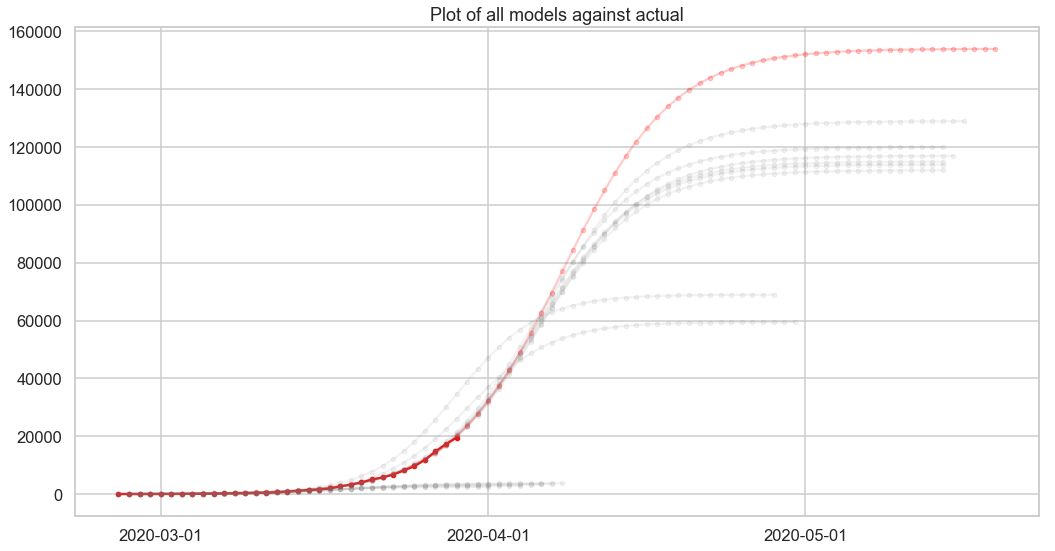

In [183]:
import matplotlib.dates as mdates

months = mdates.MonthLocator()  # every month
days = mdates.DayLocator()
months_fmt = mdates.DateFormatter('%Y-%m-%d')

fig, ax = plt.subplots(1,1,figsize=(15, 8))
ax.plot(gb_df.loc[start:, 'Actual'], marker='.', color='red')

for date in best_fit_df.index[:-1]:
    sig_case_lst = []
    duration = best_fit_df.loc[date, 'duration']
    peak = best_fit_df.loc[date, 'peak']
    spread = best_fit_df.loc[date, 'spread']
    start = best_fit_df.loc[date, 'start']
    for i in range(0, duration):
        sig_case_lst.append(sig_pred_case(i, duration=duration, peak=peak, spread=spread))
    pred_df = pd.DataFrame({'Prediction': sig_case_lst}, index=pd.date_range(start, periods=duration))
    ax.plot(pred_df['Prediction'], marker='.', color='gray', alpha=0.1)

date = best_fit_df.index[-1]
sig_case_lst = []
duration = best_fit_df.loc[date, 'duration']
peak = best_fit_df.loc[date, 'peak']
spread = best_fit_df.loc[date, 'spread']
start = best_fit_df.loc[date, 'start']
for i in range(0, duration):
    sig_case_lst.append(sig_pred_case(i, duration=duration, peak=peak, spread=spread))
pred_df = pd.DataFrame({'Prediction': sig_case_lst}, index=pd.date_range(start, periods=duration))
ax.plot(pred_df['Prediction'], marker='.', color='red', alpha=0.2)
    
ax.set_title('Plot of all models against actual')

ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(months_fmt)
ax.xaxis.set_minor_locator(days)

ax.format_xdata = mdates.DateFormatter("%Y-%m%-%d")
plt.tight_layout()
plt.show()

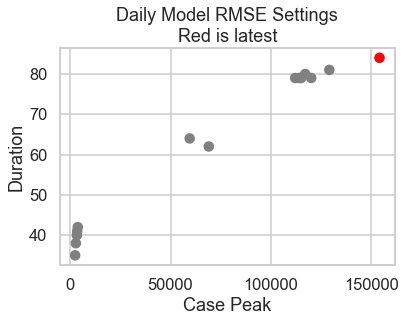

In [184]:
color_lst = ['gray'] * int(len(best_fit_df) - 1)
color_lst.append('red')
plt.scatter(x=best_fit_df['peak'],
            y=best_fit_df['duration'],
            c=color_lst)
plt.title('Daily Model RMSE Settings\nRed is latest')
plt.xlabel('Case Peak')
plt.ylabel('Duration')
plt.show()

## USA

/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/ipykernel_launcher.py:47: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


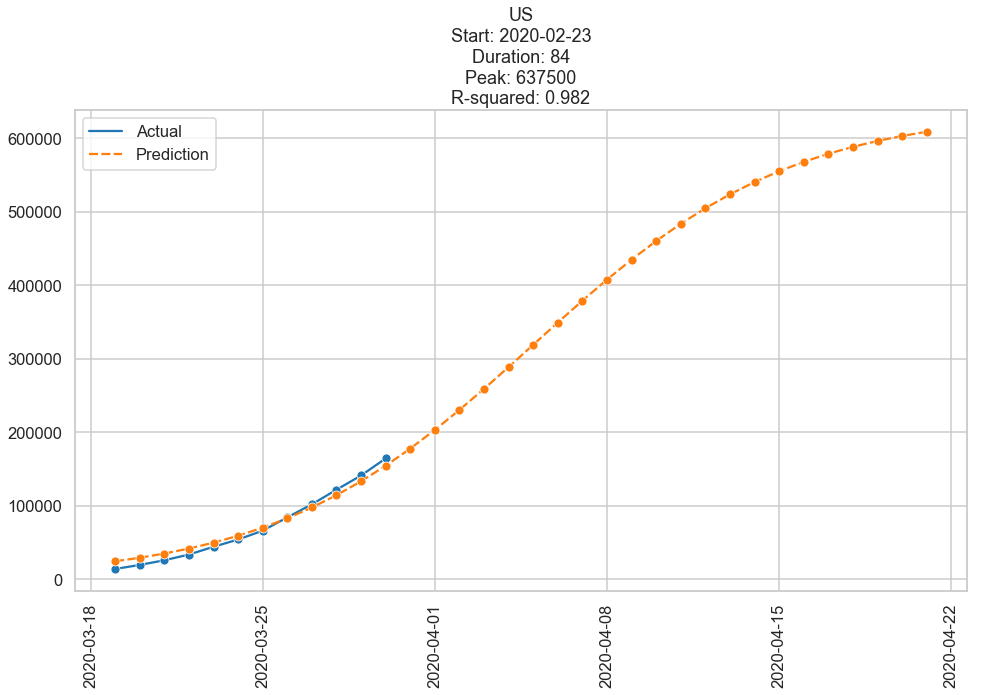

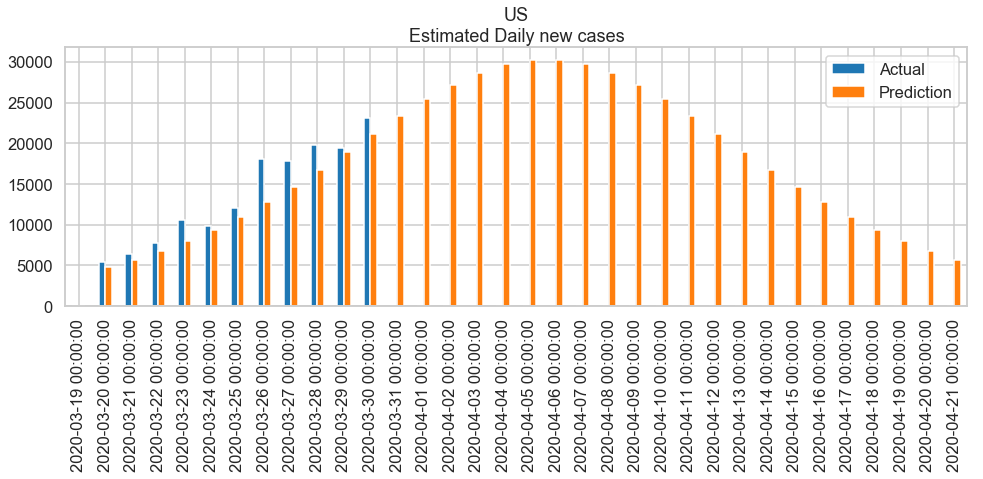

In [219]:
country = 'US'
#start_str = '2020-02-28'
start_str = '2020-02-23' 
peak_guess = 750000
duration_guess = 7*12+4

# fix errors
#idx = tidy_df['Country/Region'] == country
#idx &= tidy_df.index == pd.to_datetime('2020-03-23')
#tidy_df.loc[idx, 'Cases'] = 1642 + 10168

tidy_df = add_today(tidy_df, country, 164000)

us_df = plot_country(country, start_str, peak_guess, duration_guess,
                     strategy='rmse')

## China

/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/ipykernel_launcher.py:47: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


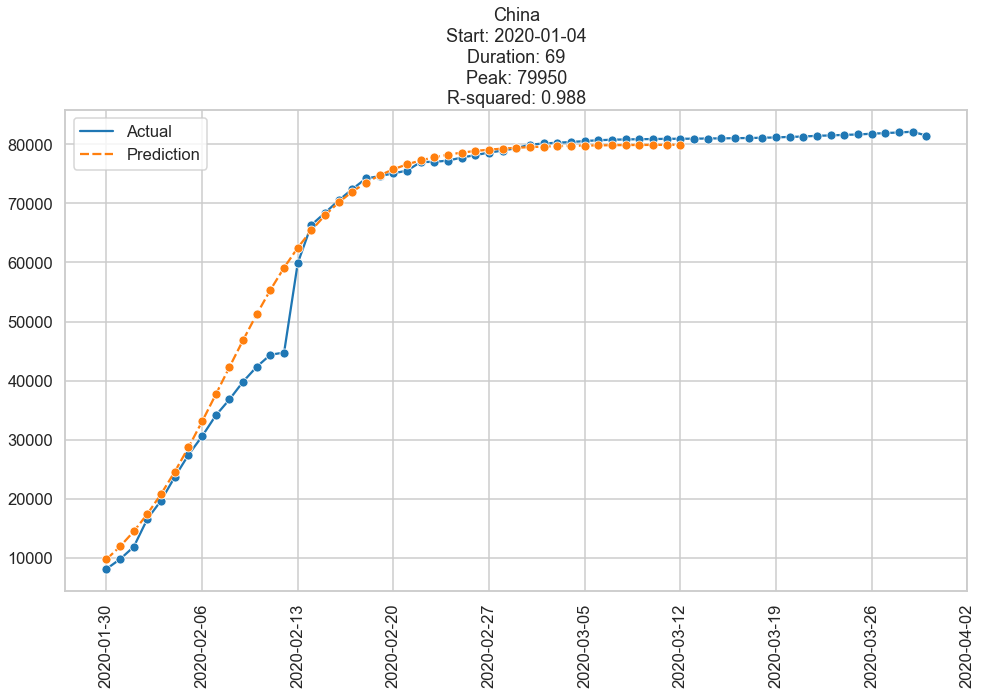

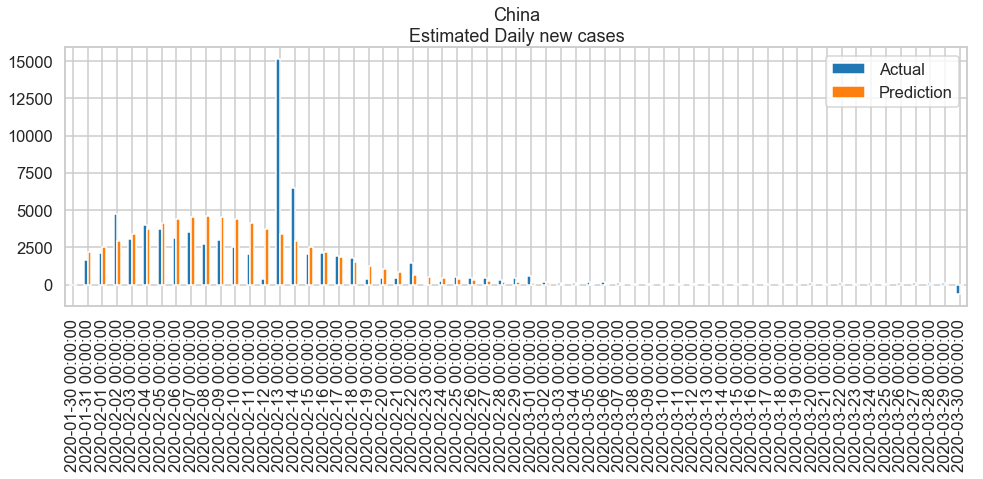

In [201]:
country = 'China'
start_str = '2020-01-04'
peak_guess = 82000
duration_guess = 72

tidy_df = add_today(tidy_df, 'Hubei', 81470, province=True)

cn_df = plot_country(country, start_str, peak_guess, duration_guess,
                     strategy='best_fit_last', offset=60)

## Italy
Italy is the same population as the UK, and a similar area and population density - is it much different?
The most interesting thing about Italy statistically, is I can only fit the middle of the curve, if we I start much earlier than other countries. My heuristic is to pick the day from which day on day increases in cases begin to occur. In Italies case, this is 9 days before that. Perhaps there was a change in testing strategy, or some time missing cases which went on to produce the later cases which were tested as positive?

/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/ipykernel_launcher.py:47: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


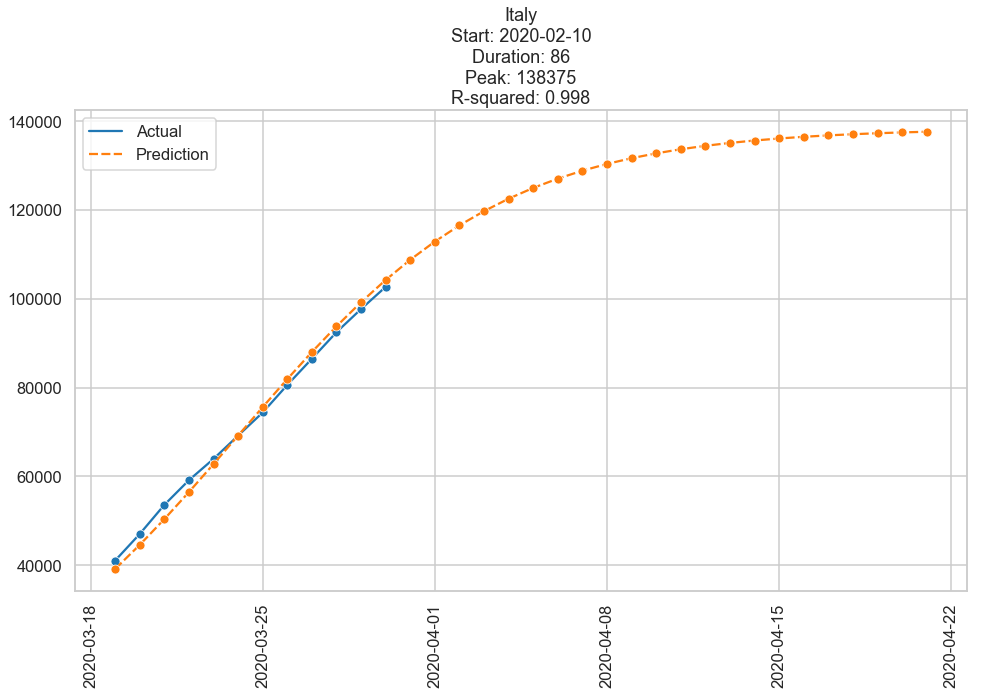

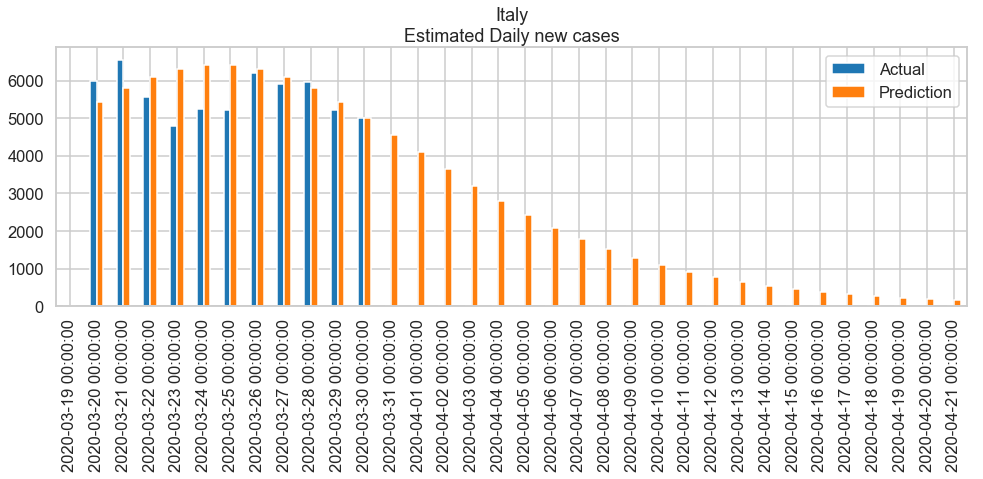

In [195]:
country = 'Italy'
start_str = '2020-02-10'
peak_guess = 135000
duration_guess = (7*13)-1

# fix 12th March error
idx = tidy_df['Country/Region'] == country
idx &= tidy_df.index == pd.to_datetime('2020-03-12')
tidy_df.loc[idx, 'Cases'] = 15113
idx = tidy_df['Country/Region'] == country
idx &= tidy_df.index == pd.to_datetime('2020-03-23')
tidy_df.loc[idx, 'Cases'] = 63927

tidy_df = add_today(tidy_df, country, 102689)

it_df = plot_country(country, start_str, peak_guess, duration_guess,
                     spread=16, strategy='rmse')

## Germany
Germany performs a very high percentage of testing. So their total confirmed cases are much closer to the likely figure in their population. The UK only test cases that need hospital care.

/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/ipykernel_launcher.py:47: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


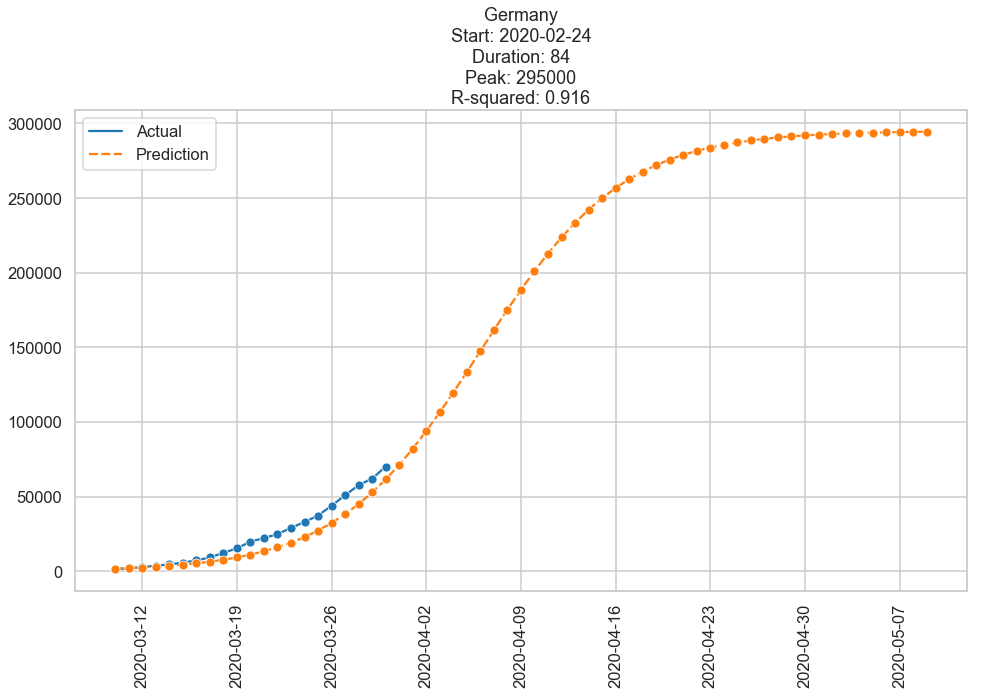

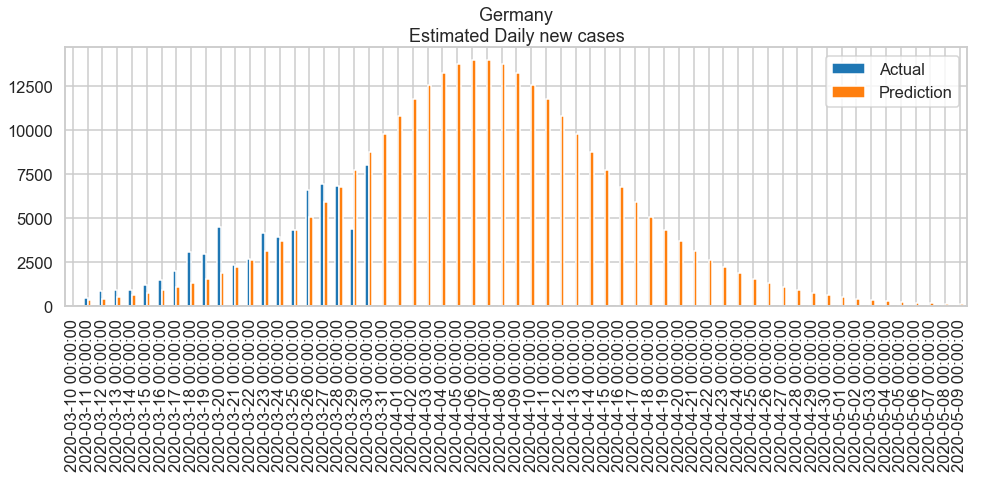

In [203]:
country = 'Germany'
start_str = '2020-02-24'
peak_guess = 200000
duration_guess = 7*12+4

# fix 12th March error
idx = tidy_df['Country/Region'] == country
idx &= tidy_df.index == pd.to_datetime('2020-03-12')
tidy_df.loc[idx, 'Cases'] = 2745
idx = tidy_df['Country/Region'] == country
idx &= tidy_df.index == pd.to_datetime('2020-03-23')
tidy_df.loc[idx, 'Cases'] = 29056

tidy_df = add_today(tidy_df, country, 70095)

de_df = plot_country(country, start_str, peak_guess, duration_guess,
                     strategy='rmse', offset=20)

## Singapore
Singapore is incredible - it's both very low and very long. They dealt with SARS before, and yet they have dense population density.

/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/ipykernel_launcher.py:47: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


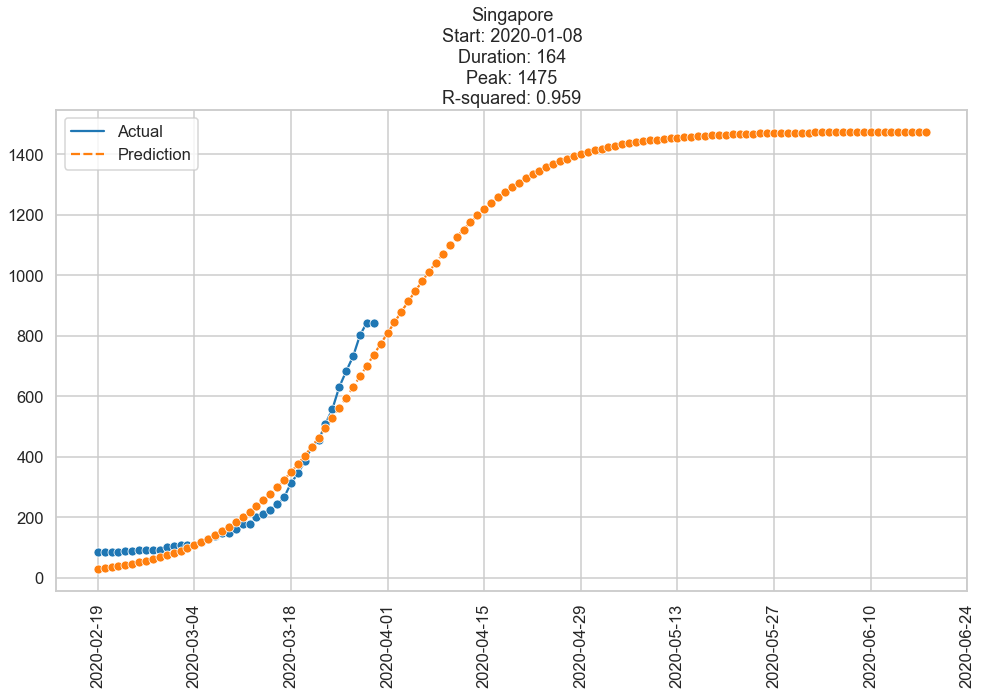

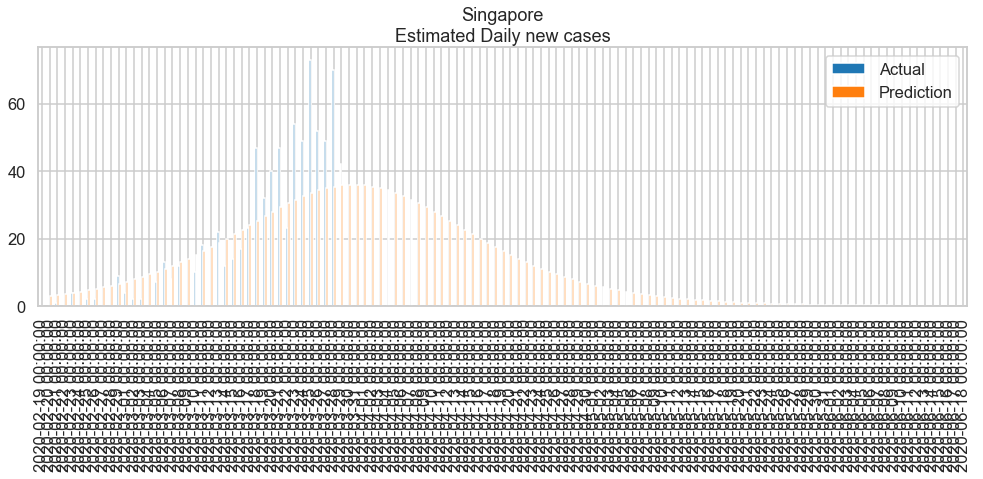

In [204]:
country = 'Singapore'
start_str = '2020-01-08'
peak_guess = 1000
duration_guess = 7*24

# fix errors
idx = tidy_df['Country/Region'] == country
idx &= tidy_df.index == pd.to_datetime('2020-03-23')
tidy_df.loc[idx, 'Cases'] = 509

tidy_df = add_today(tidy_df, country, 844)

sn_df = plot_country(country, start_str, peak_guess, duration_guess,
                     strategy='rmse', offset=40)

## Spain
Spain appears to have the worst out break in Europe, especially when you adjust cases per capita. This has recently tailed significantly - it that because the spread was faster and higher? Or is there a new datum for test cases which is naturally lower? e.g. in the UK we just test hospital admissions with flu/respiratory conditions. Whereas Germany tests many more scenarios.

/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/ipykernel_launcher.py:47: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


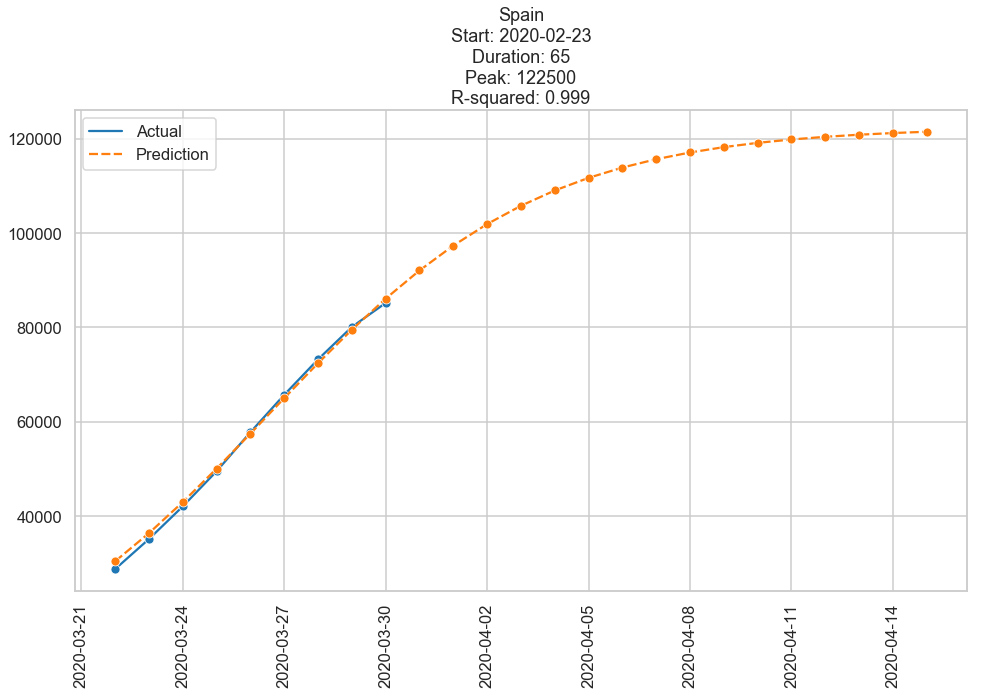

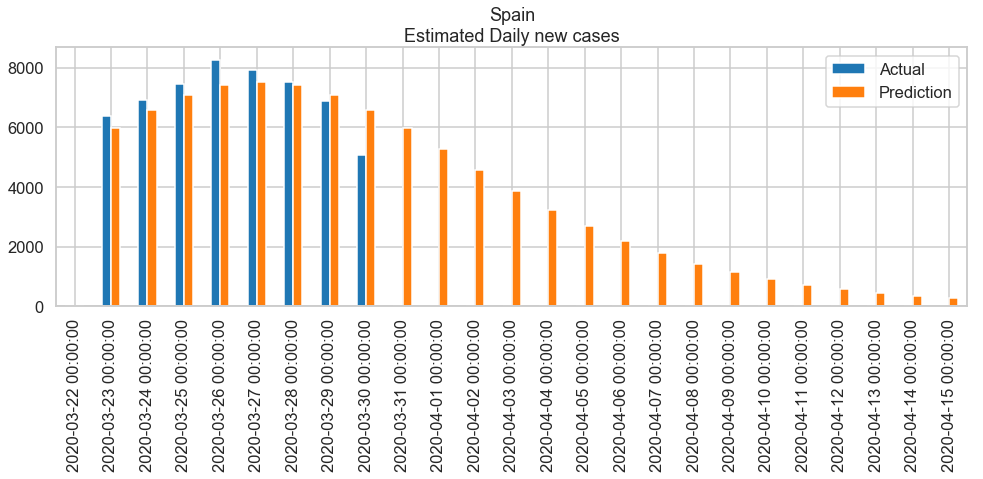

In [223]:
country = 'Spain'
start_str = '2020-02-23'
peak_guess = 100000
duration_guess = 7*9

idx = tidy_df['Country/Region'] == country
idx &= tidy_df.index == pd.to_datetime('2020-03-24')
tidy_df.loc[idx, 'Cases'] = 42058

tidy_df = add_today(tidy_df, country, 85195)

es_df = plot_country(country, start_str, peak_guess, duration_guess,
                     spread=16, strategy='rmse')

## Korea, South

/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/ipykernel_launcher.py:47: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


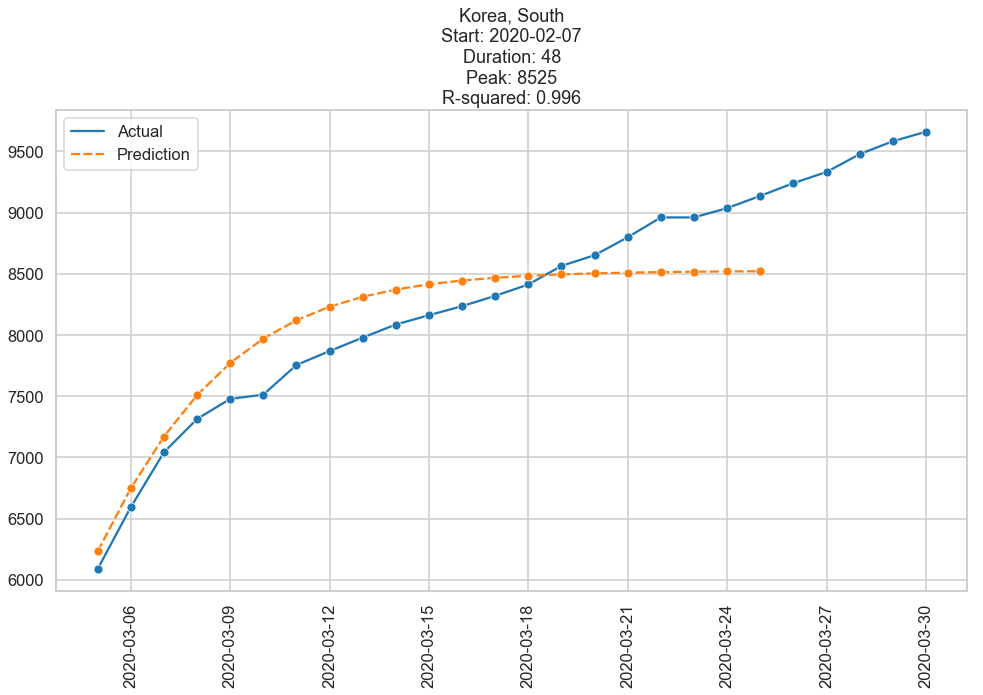

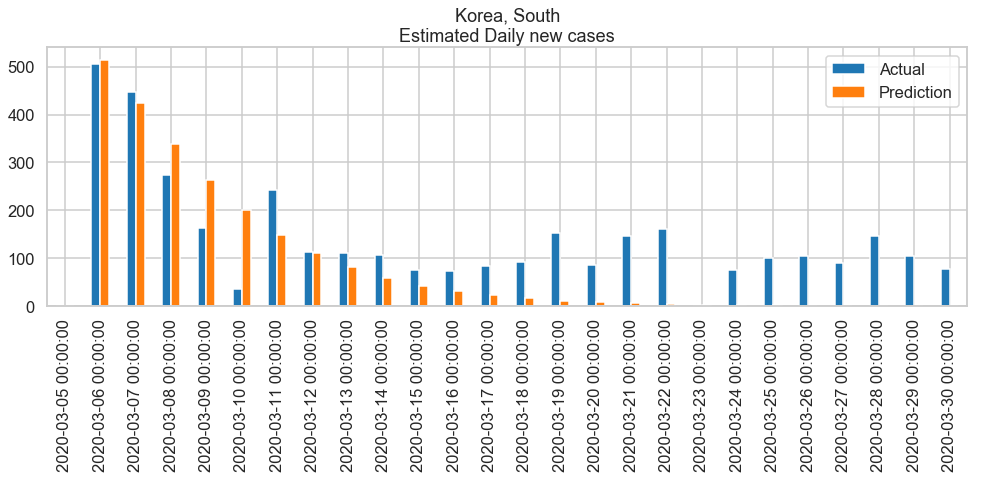

In [205]:
country = 'Korea, South'
start_str = '2020-02-07'
peak_guess = 11000
duration_guess = 48

tidy_df = add_today(tidy_df, country, 9661)

ks_df = plot_country(country, start_str, peak_guess, duration_guess, offset=25)

## Netherlands

/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/ipykernel_launcher.py:47: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


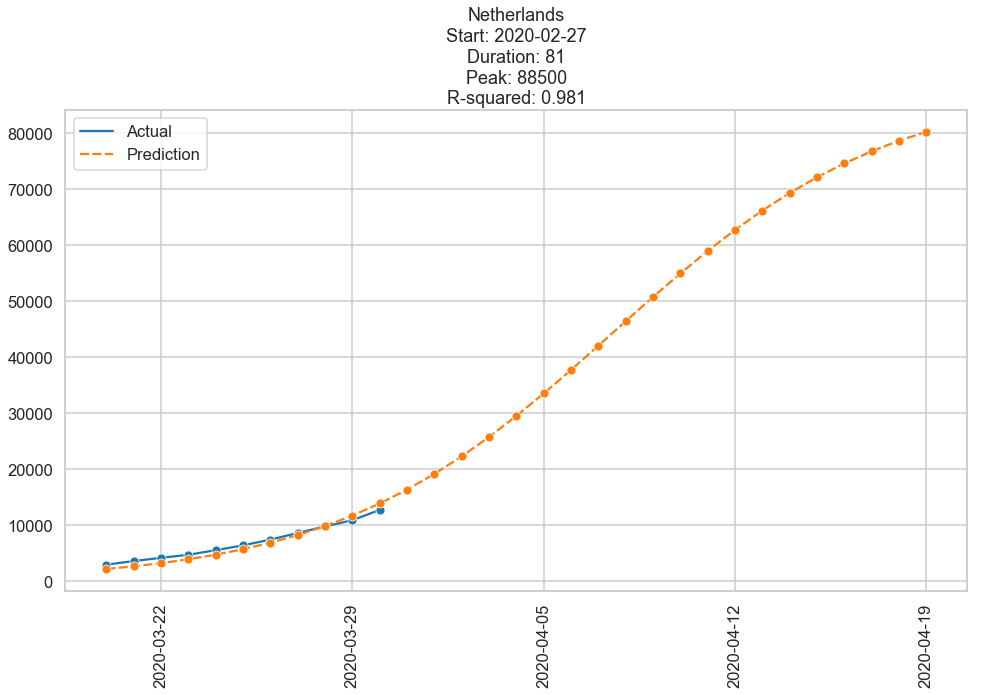

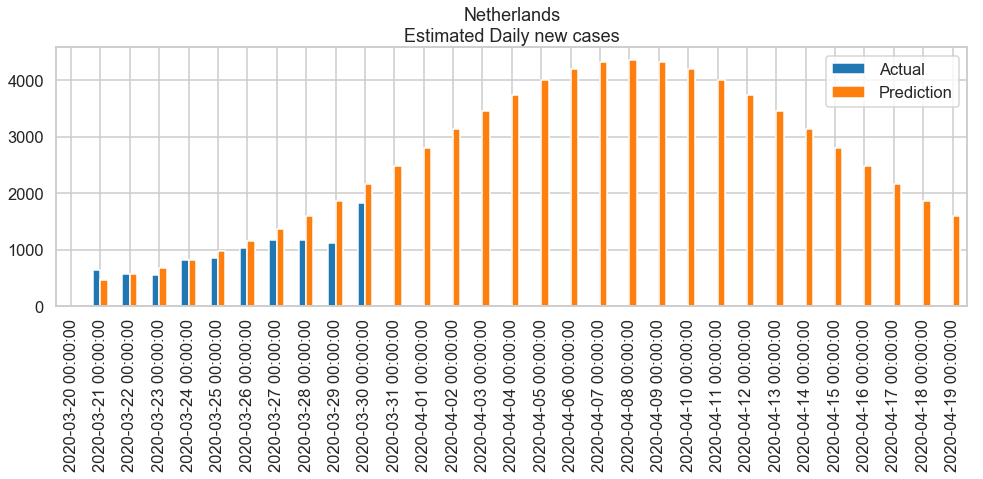

In [207]:
country = 'Netherlands'
start_str = '2020-02-27'
peak_guess = 60000
duration_guess = 7*12

idx = tidy_df['Province/State'] == country
idx &= tidy_df.index == pd.to_datetime('2020-03-23')
tidy_df.loc[idx, 'Cases'] = 4749

tidy_df = add_today(tidy_df, country, 12762, province=True)

nd_df = plot_country(country, start_str, peak_guess, duration_guess,
                     offset=10)

## Ireland

/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/ipykernel_launcher.py:47: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


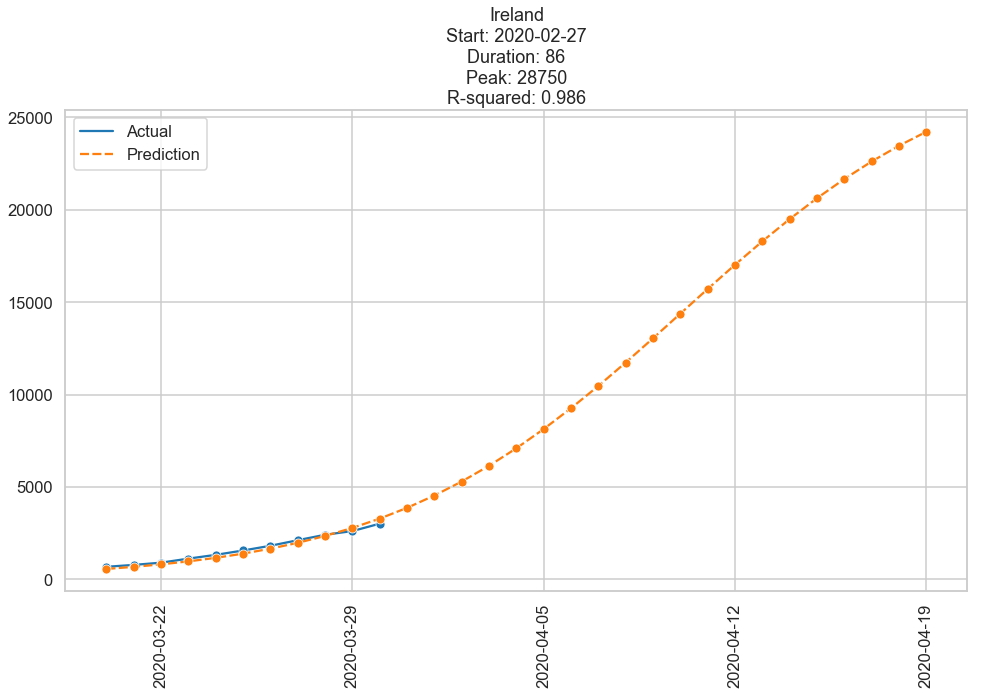

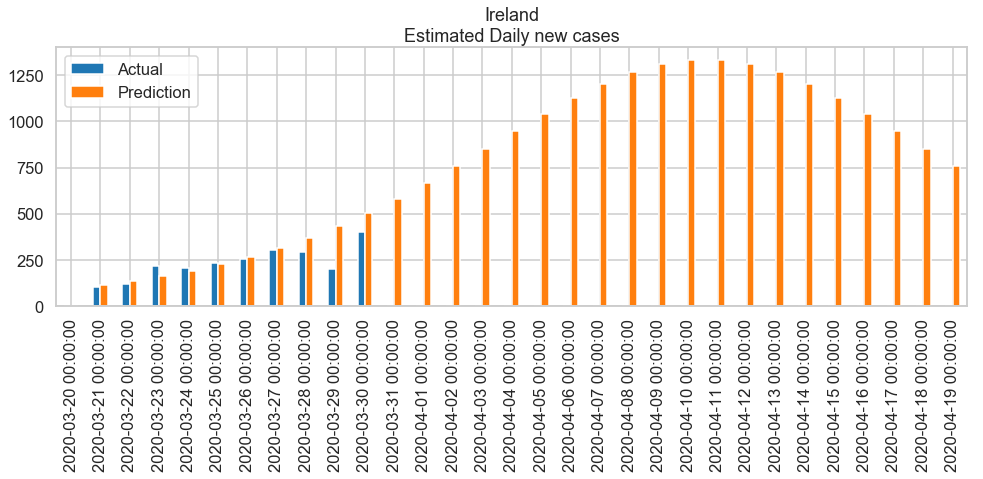

In [208]:
country = 'Ireland'
start_str = '2020-02-27'
peak_guess = 25000
duration_guess = 7*12

tidy_df = add_today(tidy_df, country, 3015)

ei_df = plot_country(country, start_str, peak_guess, duration_guess)

## Romania

/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/ipykernel_launcher.py:47: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


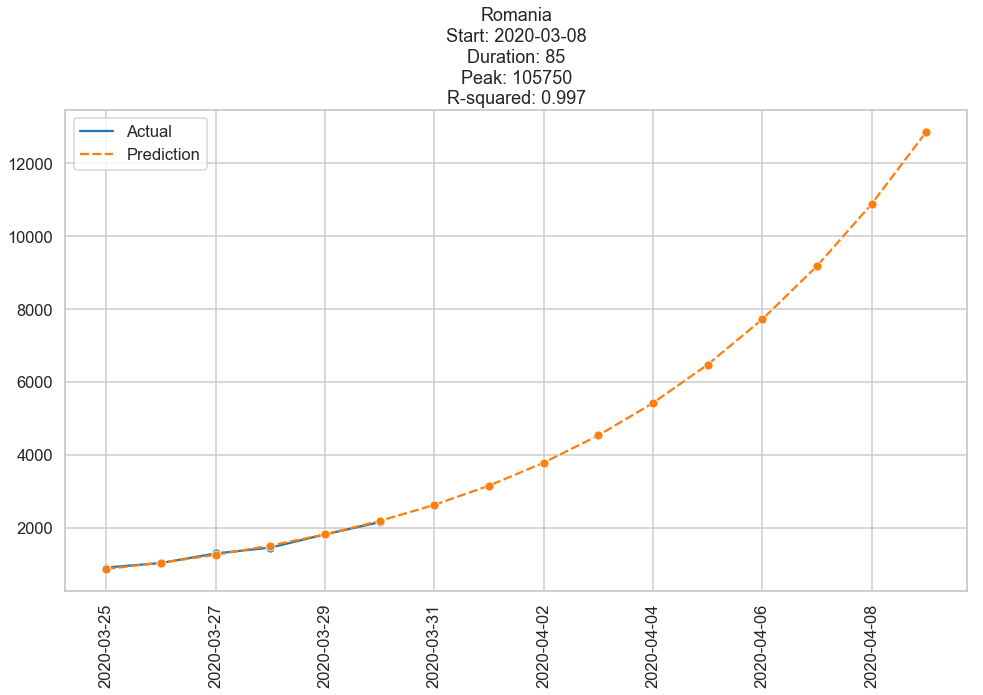

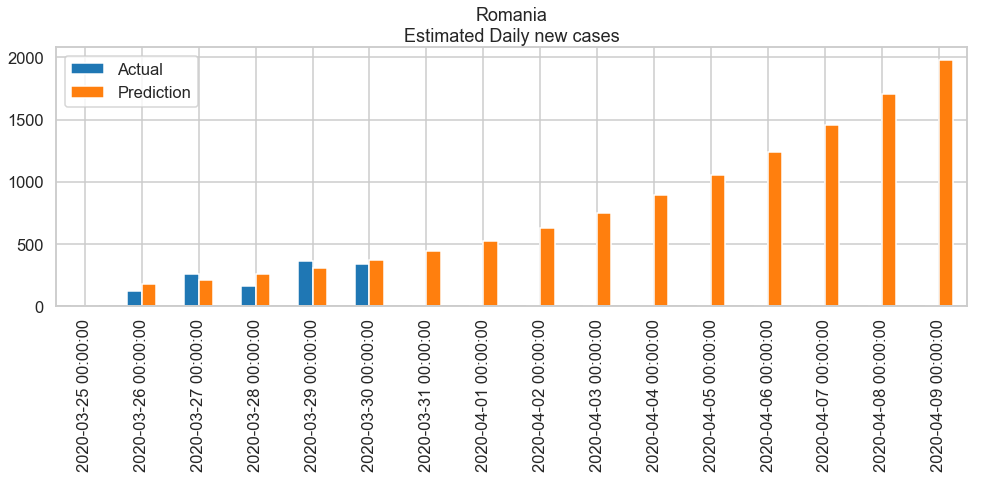

In [209]:
country = 'Romania'
start_str = '2020-03-08'
peak_guess = 90000
duration_guess = 7*12

tidy_df = add_today(tidy_df, country, 2152)

ei_df = plot_country(country, start_str, peak_guess, duration_guess, strategy='rmse', offset=5)

## France

/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/ipykernel_launcher.py:47: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


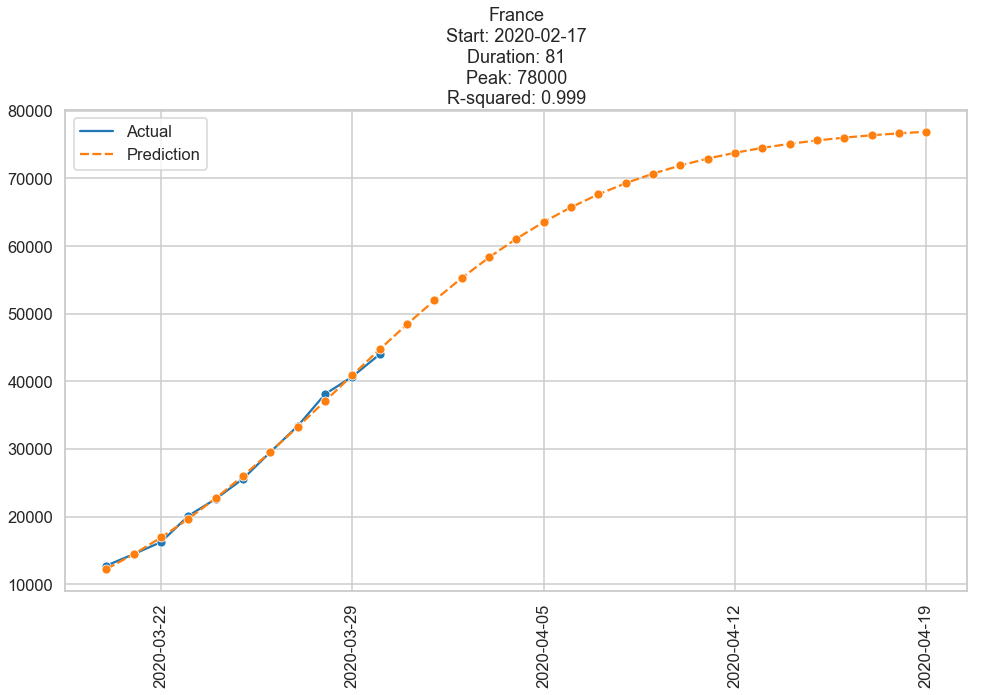

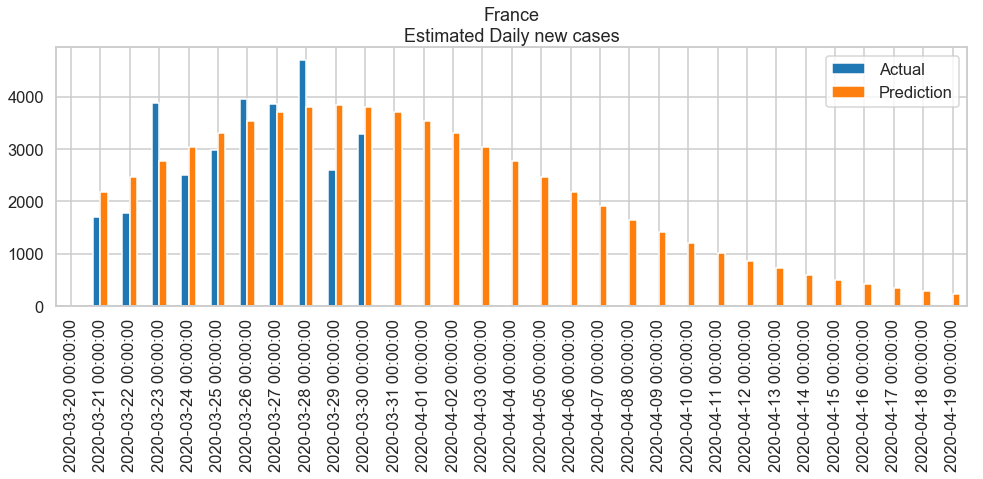

In [198]:
country = 'France'
start_str = '2020-02-17'
peak_guess = 60000
duration_guess = 7*12

# fix 12th March error
idx = tidy_df['Province/State'] == country
idx &= tidy_df.index == pd.to_datetime('2020-03-12')
tidy_df.loc[idx, 'Cases'] = 2876
idx = tidy_df['Province/State'] == country
idx &= tidy_df.index == pd.to_datetime('2020-03-15')
tidy_df.loc[idx, 'Cases'] = 5423
idx = tidy_df['Province/State'] == country
idx &= tidy_df.index == pd.to_datetime('2020-03-23')
tidy_df.loc[idx, 'Cases'] = 19856

tidy_df = add_today(tidy_df, country, 44000, province=True)

fr_df = plot_country(country, start_str, peak_guess, duration_guess,
                     strategy='rmse', spread=16, offset=10)

## Australia

/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/ipykernel_launcher.py:47: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


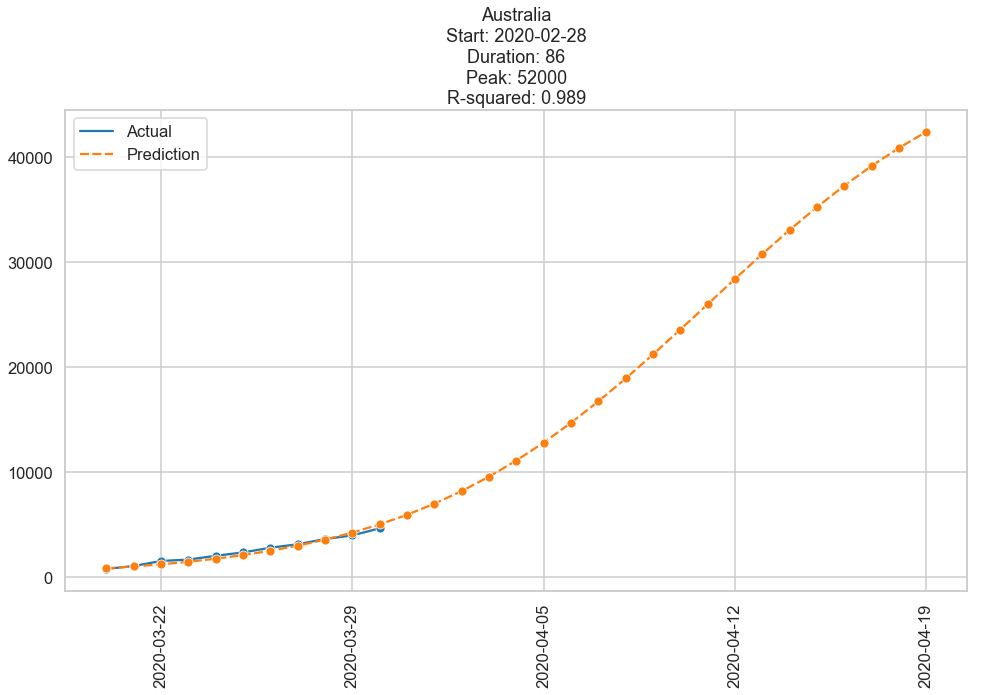

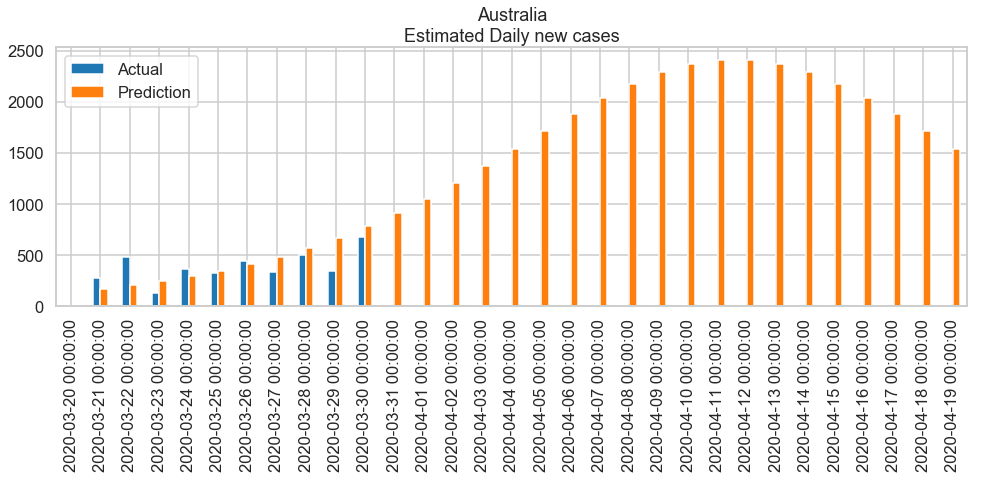

In [211]:
country = 'Australia'
start_str = '2020-02-28'
peak_guess = 40000
duration_guess = 7*12
tidy_df = add_today(tidy_df, 'New South Wales', 4663, province=True)

au_df = plot_country(country, start_str, peak_guess, duration_guess)

## Sweden
Sweden is interesting - it's made up of distinct S-curves. So fitting just one, isn't working well. Singapore was similar. It will be interesting to know why - Sweden are surpressing, not containing the outbreak. Which is very different to Singapore. Granted Sweden is much less dense - but people still live in relatively large cities.

/Users/Brian/anaconda3/envs/datacamp/lib/python3.6/site-packages/ipykernel_launcher.py:47: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.


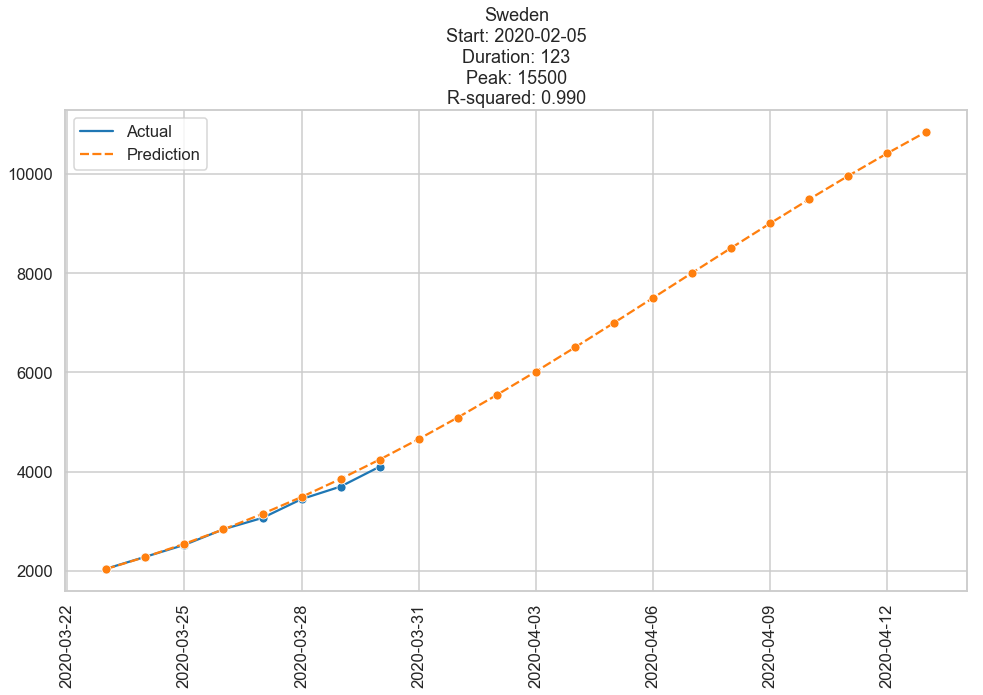

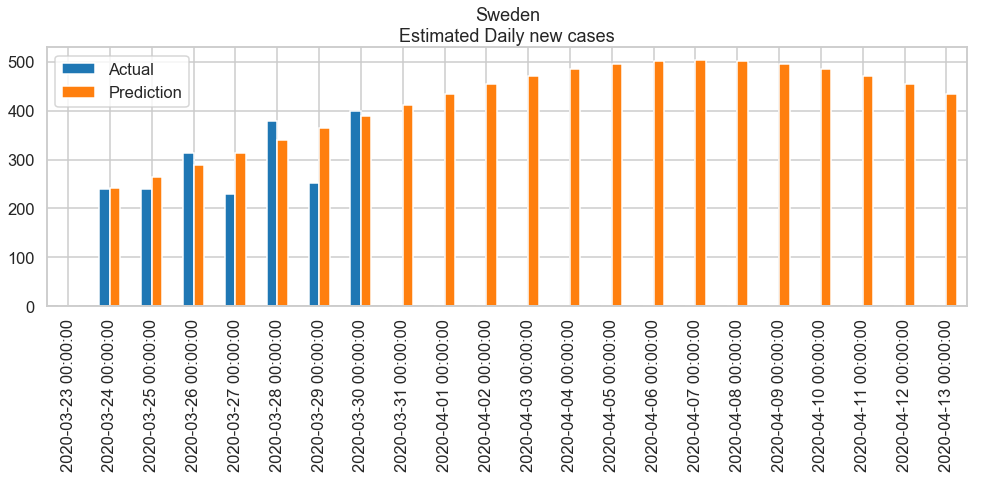

In [213]:
country = 'Sweden'
start_str = '2020-02-05'
peak_guess = 20000
duration_guess = 7*18
tidy_df = add_today(tidy_df, country, 4100)

au_df = plot_country(country, start_str, peak_guess, duration_guess,
                     spread=16, offset=7)

## Comparison
Compare each country at the same point in the virus spread.

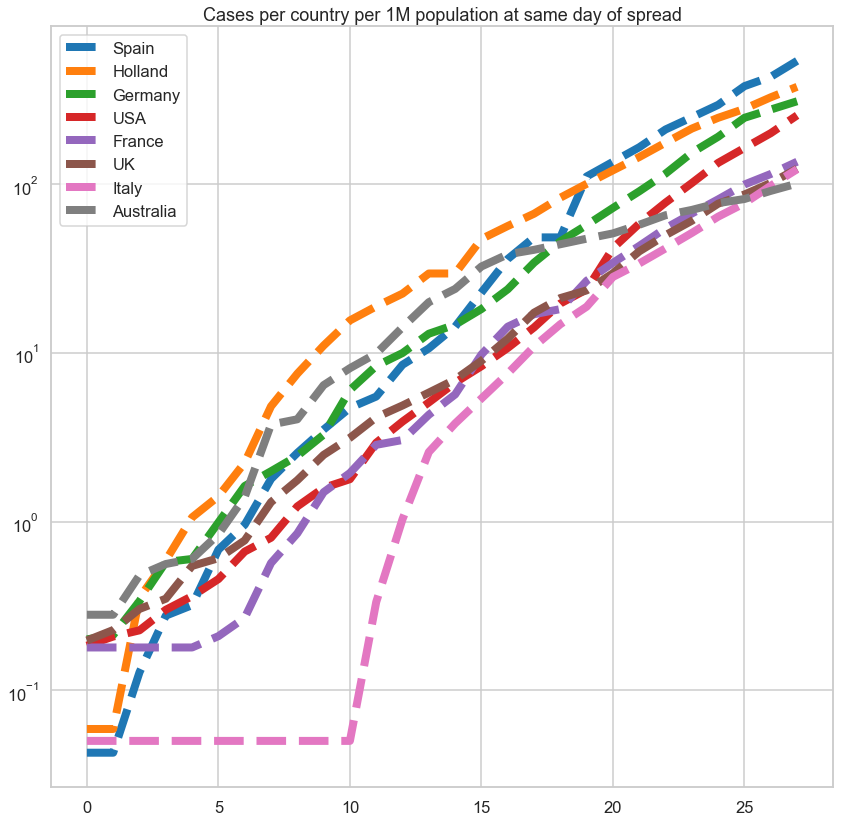

In [218]:
length = 28
temp_df = pd.DataFrame({
    'Spain': es_df.loc['2020-02-23':, 'Actual'].dropna().values[:length]/47,
    'Holland': nd_df.loc['2020-02-27':, 'Actual'].dropna().values[:length]/17,
    'Germany': de_df.loc['2020-02-24':, 'Actual'].dropna().values[:length]/80,
    'USA': us_df.loc['2020-02-28':, 'Actual'].dropna().values[:length]/327,
    'France': fr_df.loc['2020-02-20':, 'Actual'].dropna().values[:length]/67,
    'UK': gb_df.loc['2020-02-26':, 'Actual'].dropna().values[:length]/66,
    'Italy': it_df.loc['2020-02-10':, 'Actual'].dropna().values[:length]/60,
    'Australia': au_df.loc['2020-02-27':, 'Actual'].dropna().values[:length]/25,
    })
temp_df.plot(linestyle='--', linewidth=8, figsize=(14,14))
plt.title('Cases per country per 1M population at same day of spread')
plt.yscale('log')
plt.show()